# Transfer learning in AWS using INCEPTION V3

In this notebook I will demonstrate how to use a pretrained Inception V3 model to solve a binary classification problem.

The notebook is based on the "TF2.0 Transfer Learning" turtorial created by Lazy Programmer Inc:
    
- https://colab.research.google.com/drive/1hHH95k0ixzRfkET30FsZ19MzVXEtrwiT

## Setup

In [1]:
import tensorflow as tf

# More imports
from tensorflow.keras.layers import Input, Dense, Flatten

#from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
#  preprocess_input

from tensorflow.keras.applications import InceptionV3 as PretrainedModel 
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

## Download and process the data

In [2]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-06-12 00:50:55--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.80.48, 104.31.81.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  25.6MB/s    in 5m 37s  

2020-06-12 00:57:08 (1.26 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [3]:
!unzip -qq -o Food-5K.zip

In [4]:
!ls

AWS_INCEPTION_V3_Notebook.ipynb  Food-5K  Food-5K.zip  __MACOSX


In [5]:
!mv Food-5K/* .

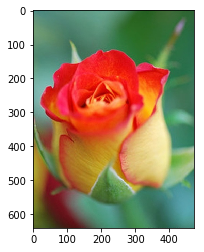

In [6]:
# look at an image for fun
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

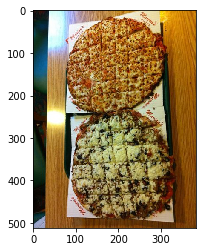

In [7]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

In [8]:
!mkdir data

In [9]:
# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [10]:
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [11]:
train_path = 'data/train'
valid_path = 'data/test'

In [12]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [13]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [14]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

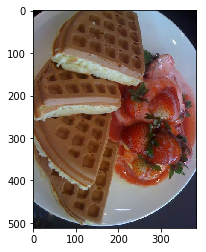

In [15]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

## Define model hyperparameters

In [16]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 1s 0us/step


In [17]:
# map the data into feature vectors
x = Flatten()(ptm.output)

In [18]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [19]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [21]:
batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

# Figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

## Train the model

In [23]:
# populate X_train and Y_train
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y
  
  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [24]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
1000


In [25]:
X_train.max(), X_train.min()

(45.327247619628906, -0.0)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [27]:
# Try the built-in logistic regression

from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.993


In [33]:
# Do logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

In [34]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc'])

In [35]:
# Can try both normalized and unnormalized data
r = linearmodel.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid, Y_valid),
)

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 1s 473us/sample - loss: 0.8478 - acc: 0.8337 - val_loss: 0.0490 - val_acc: 0.9830
Epoch 2/10
3000/3000 [==============================] - 1s 226us/sample - loss: 0.0845 - acc: 0.9803 - val_loss: 0.0454 - val_acc: 0.9830
Epoch 3/10
3000/3000 [==============================] - 1s 236us/sample - loss: 0.0480 - acc: 0.9897 - val_loss: 0.0475 - val_acc: 0.9870
Epoch 4/10
3000/3000 [==============================] - 1s 225us/sample - loss: 0.0229 - acc: 0.9940 - val_loss: 0.0462 - val_acc: 0.9840
Epoch 5/10
3000/3000 [==============================] - 1s 239us/sample - loss: 0.0122 - acc: 0.9970 - val_loss: 0.0670 - val_acc: 0.9810
Epoch 6/10
3000/3000 [==============================] - 1s 224us/sample - loss: 0.0077 - acc: 0.9983 - val_loss: 0.0521 - val_acc: 0.9790
Epoch 7/10
3000/3000 [==============================] - 1s 238us/sample - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0574 - va

## Plot the loss and accuracy

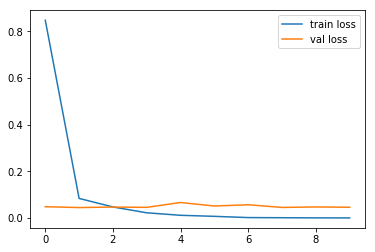

In [36]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

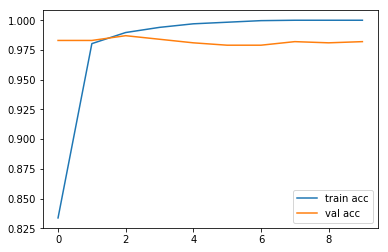

In [37]:
# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()